# Analysis of Multilingual Mobile App Reviews

This notebook explores a dataset of mobile app reviews. The goal is to clean the data, find interesting patterns, and visualize the key insights.

**Author:** Sandeep Malviya

---

## Setup and Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import kagglehub
import os
import scipy.stats as stats

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported.")

Libraries imported.


In [2]:
# Load the dataset from Kaggle Hub
try:
    print("Downloading dataset...")
    path = kagglehub.dataset_download(
        "pratyushpuri/multilingual-mobile-app-reviews-dataset-2025"
    )
    csv_path = os.path.join(path, 'multilingual_mobile_app_reviews_2025.csv')
    df = pd.read_csv(csv_path)
    print(f"Dataset loaded. Shape: {df.shape}")
except Exception as e:
    print(f"Error loading dataset: {e}")

Dataset loaded. Shape: (2514, 15)


## Initial Exploration and Cleaning

In [3]:
print("Data Overview:")
df.info()

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Dropping rows where review_text is missing, as it's essential for analysis.
df.dropna(subset=['review_text'], inplace=True)

# Convert review_date to datetime objects
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')

# Fill missing ratings with the median. It's a safe bet for numerical data.
rating_median = df['rating'].median()
df['rating'].fillna(rating_median, inplace=True)

# For categorical data, 'Unknown' is a better placeholder than dropping rows.
df['user_country'].fillna('Unknown', inplace=True)
df['user_gender'].fillna('Unknown', inplace=True)
df['app_version'].fillna('Unknown', inplace=True)

# Clean up the app_version format by removing the 'v' prefix
df['app_version'] = df['app_version'].astype(str).str.lstrip('v')

# Ensure numerical columns are the right type
df['user_age'] = df['user_age'].astype(int)
df['num_helpful_votes'] = df['num_helpful_votes'].astype(int)


print(f"\nCleaned data shape: {df.shape}")

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_id          2514 non-null   int64  
 1   user_id            2514 non-null   int64  
 2   app_name           2514 non-null   object 
 3   app_category       2514 non-null   object 
 4   review_text        2455 non-null   object 
 5   review_language    2514 non-null   object 
 6   rating             2477 non-null   float64
 7   review_date        2514 non-null   object 
 8   verified_purchase  2514 non-null   bool   
 9   device_type        2514 non-null   object 
 10  num_helpful_votes  2514 non-null   int64  
 11  user_age           2514 non-null   float64
 12  user_country       2473 non-null   object 
 13  user_gender        1927 non-null   object 
 14  app_version        2484 non-null   object 
dtypes: bool(1), float64(2), int64(3), object(9)
memory usage:

## Feature Engineering

In [4]:
# Text-based features
df['review_length'] = df['review_text'].str.len()
df['review_word_count'] = df['review_text'].str.split().str.len()

# Time-based features
df['review_year'] = df['review_date'].dt.year
df['review_month'] = df['review_date'].dt.month
df['review_day_of_week'] = df['review_date'].dt.day_name()

# Categorical features for easier grouping
def categorize_rating(rating):
    if rating >= 4.5: return 'Excellent'
    if rating >= 4.0: return 'Good'
    if rating >= 3.0: return 'Average'
    if rating >= 2.0: return 'Poor'
    return 'Very Poor'

df['rating_category'] = df['rating'].apply(categorize_rating)

def categorize_age(age):
    if age < 18: return 'Teen'
    if age < 25: return 'Young Adult'
    if age < 35: return 'Adult'
    if age < 50: return 'Middle Age'
    return 'Senior'

df['age_group'] = df['user_age'].apply(categorize_age)

print("New features created.")
df.head()


New features created.


,review_id,user_id,app_name,app_category,review_text,review_language,rating,review_date,verified_purchase,device_type,...,user_country,user_gender,app_version,review_length,review_word_count,review_year,review_month,review_day_of_week,rating_category,age_group
0,1,1967825,MX Player,Travel & Local,Qui doloribus consequuntur. Perspiciatis tempo...,no,1.3,2024-10-09 19:26:40,True,Android Tablet,...,China,Female,1.4,86,10,2024,10,Wednesday,Very Poor,Teen
1,2,9242600,Tinder,Navigation,"Great app but too many ads, consider premium v...",ru,1.6,2024-06-21 17:29:40,True,iPad,...,Germany,Male,8.9,53,9,2024,6,Friday,Very Poor,Young Adult
2,3,7636477,Netflix,Dating,The interface could be better but overall good...,es,3.6,2024-10-31 13:47:12,True,iPad,...,Nigeria,Male,2.8.37.5926,58,9,2024,10,Thursday,Average,Senior
3,4,209031,Venmo,Productivity,"Latest update broke some features, please fix ...",vi,3.8,2025-03-12 06:16:22,True,iOS,...,India,Female,10.2,51,8,2025,3,Wednesday,Average,Senior
4,5,7190293,Google Drive,Education,"Perfect for daily use, highly recommend to eve...",tl,3.2,2024-04-21 03:48:27,True,iPad,...,South Korea,Prefer not to say,4.7,52,8,2024,4,Sunday,Average,Middle Age


## Visual Analysis

### General Overview

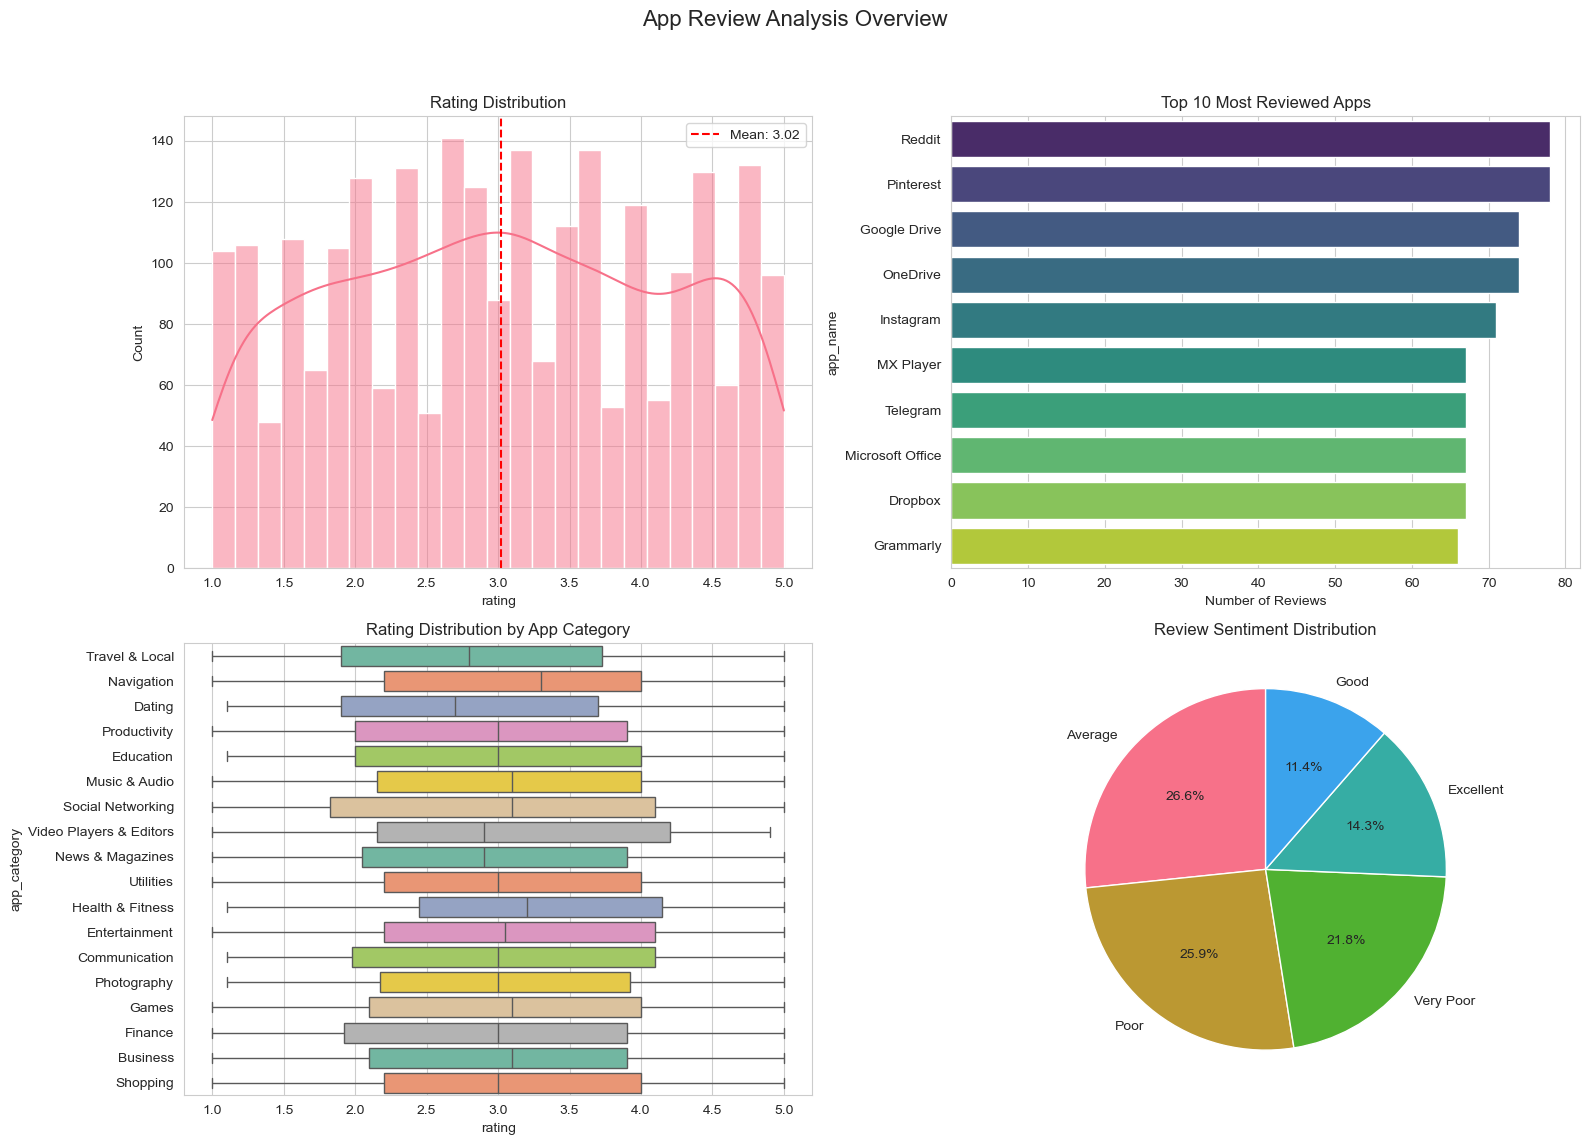

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('App Review Analysis Overview', fontsize=16)

# Rating distribution
sns.histplot(data=df, x='rating', bins=25, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Rating Distribution')
axes[0, 0].axvline(df['rating'].mean(), color='red', linestyle='--', label=f'Mean: {df["rating"].mean():.2f}')
axes[0, 0].legend()

# Top 10 apps by review count
top_apps = df['app_name'].value_counts().head(10)
sns.barplot(x=top_apps.values, y=top_apps.index, ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('Top 10 Most Reviewed Apps')
axes[0, 1].set_xlabel('Number of Reviews')

# Rating by category
sns.boxplot(data=df, y='app_category', x='rating', ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Rating Distribution by App Category')

# Sentiment distribution
sentiment_counts = df['rating_category'].value_counts()
axes[1, 1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Review Sentiment Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Deeper Dive: Correlations and Demographics

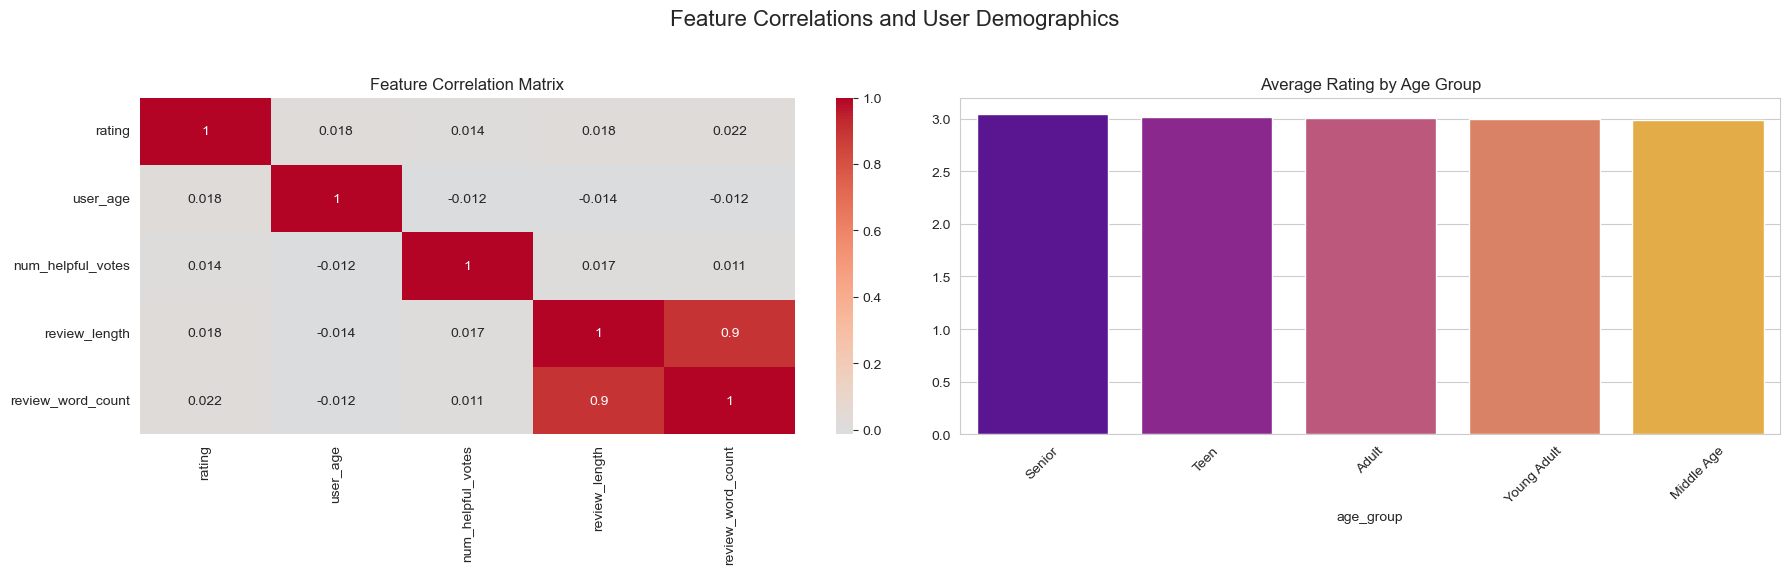

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Feature Correlations and User Demographics', fontsize=16)

# Correlation heatmap
numeric_cols = ['rating', 'user_age', 'num_helpful_votes', 'review_length', 'review_word_count']
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Feature Correlation Matrix')

# Age group analysis
age_rating = df.groupby('age_group')['rating'].mean().sort_values(ascending=False)
sns.barplot(x=age_rating.index, y=age_rating.values, ax=axes[1], palette='plasma')
axes[1].set_title('Average Rating by Age Group')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Statistical Tests

In [7]:
# ANOVA test for rating differences across app categories
category_groups = [df[df['app_category'] == cat]['rating'].values for cat in df['app_category'].unique()]
f_stat, p_value = stats.f_oneway(*category_groups)

print(f"ANOVA Test: Do ratings differ significantly across app categories?")
print(f"F-statistic: {f_stat:.2f}")
print(f"P-value: {p_value:.4f}\n")

# Generate a dynamic conclusion based on the p-value
conclusion = f"The ANOVA test resulted in a p-value of {p_value:.4f}. "
if p_value < 0.05:
    conclusion += ("This value is below the standard significance level of 0.05, "
                 "which suggests that there is a statistically significant difference in the average ratings across the various app categories. "
                 "We can be reasonably confident that the observed variations are not due to random chance.")
else:
    conclusion += ("This value is above the standard significance level of 0.05, "
                 "confirming what the boxplot suggested: while there are slight variations, there is no statistically significant difference "
                 "in the average ratings across the various app categories. This means we can't confidently say that one category is rated "
                 "better than another in general.")

print("---")
print("Conclusion")
print(conclusion)

ANOVA Test: Do ratings differ significantly across app categories?
F-statistic: 1.00
P-value: 0.4573

---
Conclusion
The ANOVA test resulted in a p-value of 0.4573. This value is above the standard significance level of 0.05, confirming what the boxplot suggested: while there are slight variations, there is no statistically significant difference in the average ratings across the various app categories. This means we can't confidently say that one category is rated better than another in general.
